# An analysis of housing data in King County Washington.

### Presented by: Data Chef Partners

 Objective: To help realtors identify profitable areas in their chosen county so they can help their customers buy or sell with confidence<br>
#### Families:
- Get more house for their money
- Make an investment for future gains 
- Possible rental opportunities<br>
#### Contractors
- identify hotspots for flip opportunities
- identify areas of future development for new construction ventures
- Find customers looking to rennovate<br>
#### Investors
- Identify the gold standard of house for investment opportunities


### Setting up our workspace  
- Importing necessary libraries
- Importing custom helper functions

In [1]:
# Setting up the workspace by importing all of the necessary libraries.
from importlib import reload

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import folium
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn import metrics

import scipy.stats as stats
warnings.filterwarnings('ignore')
import helper_functions as hf
reload(hf)

<module 'helper_functions' from 'C:\\Users\\Owner\\Desktop\\Data Science\\Flatiron_Projects\\mod_1_project\\dsc-v2-mod1-final-project-online-ds-ft-090919\\helper_functions.py'>

# Loading the data

In [ ]:
# Loading the data and getting a first look at it's structure and contents
df = pd.read_csv('kc_house_data.csv')
df.head(10)

In [ ]:
# Taking a look at the types of data and the information about the different columns
# Identifying extraneous values that may need to be removed or altered for cleaner processing
df.info()

In [ ]:
df.describe()

### Initial Data impressions:<br>
- __*id*__ is simply an identifier<br>
    This will be removed as it is not pertinent to the data analysis.<br>
- __*date*__ is a string.<br>
    Our initial impression is that it reflects sale dates for the property.<br>
    This should be converted to a numerical value for processing.<br>
- There are two columns related to the size, __*sqft_living and sqft_lot*__ <br>
    We will explore their relationship and determine if they are dependent on each other or not<br>
- __*floors*__ is a numerical value.<br>
    Based on our knowledge of houses we believe this may be better suited to a categorical value.<br>
    We will explore the data and convert it to either a single or multiple<br> 
    or decide if each value of floors needs it's own category.<br>
- __*waterfront*__ is definitely categorical sine a home can only be either on or off the water.<br>
    We will convert this to a binary value to represent either on or off the water.<br>
- __*sqft_basement*__ <br>
    This along with __*sqft_above*__ combined are the same as __*sqft_living*__ so we will deal with it<br>
    since the presence of a basement is more significant than the size.<br>
    'sqft_basement will then be converted to categories which will identify the presence of a basement<br>
- __*zipcode*__ and __*lat*__ and __*long*__ are both location data.<br>
    We will determine if all are necessary and treat them accordingly<br>
- __*yr_renovated*__ has many null values so they will be used to create a new feature.<br>
    we will subtract it from the last date in the database and create __*ren_period*__


### Scrubbing the Data!!

*Waterfront*

In [ ]:
# 'waterfront' is either True "1" or False "0".
# here we are changing all of the Null values to 0 to facilitate this
df['waterfront'] = df.waterfront.fillna(0)

*ID*

In [ ]:
# 'id' is an arbitrary value which is unnecesary for analysis
# here we are removing it from the dataset
df.drop(['id'], axis=1, inplace=True)



*View*

In [ ]:
# 'view' has some null values, so we will replace those with the assumption
#  that the null values represent the property not being viewed.
df['view'] = df.view.fillna(value = 0)

   *Sqft_basement*

In [ ]:
# 'sqft_basement' has some placeholders. Here we are removing those
# This also needs to be converted to numerical values for analysis
df.sqft_basement.replace(to_replace='?', value='0', inplace=True)
df.sqft_basement = df.sqft_basement.fillna(value = 0)
df.sqft_basement = df.sqft_basement.convert_objects(convert_numeric=True)

In [ ]:
df['yr_renovated'] = df.yr_renovated.fillna(value = 0)
df.yr_renovated = df.yr_renovated.replace(to_replace=0, value=df.yr_built)
    
        

In [ ]:
df['ren_period'] = 2015-df.yr_renovated

In [ ]:
df.ren_period.plot(kind='hist', bins=30)

In [ ]:
df.head()

In [ ]:
# converting to datetime for analysis
df['yr_renovated_dt'] = pd.to_datetime(df.yr_renovated.astype(int), format='%Y').dt.year
df.head(10)

In [ ]:
# converting 'date' to datetime format for processing
df['date_dt'] = pd.to_datetime(df.date)
df.head()

### Looking over the Clean, Shiny Data.

In [ ]:
df.describe()

## Saving cleaned DF as a CSV file for future use

In [ ]:
df.to_csv("cleaned_kc_house_data.csv", index=False)

# Visualizing the Data

In [2]:
dff = pd.read_csv("cleaned_kc_house_data.csv")

In [3]:
# Taking an initial look at the basic statistics of the data set
dff.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,ren_period,yr_renovated_dt,date_dt
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,...,1955,1955.0,98178,47.5112,-122.257,1340,5650,60.0,1955,2014-10-13
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,24.0,1991,2014-12-09
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,...,1933,1933.0,98028,47.7379,-122.233,2720,8062,82.0,1933,2015-02-25
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,1965,1965.0,98136,47.5208,-122.393,1360,5000,50.0,1965,2014-12-09
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,1987,1987.0,98074,47.6168,-122.045,1800,7503,28.0,1987,2015-02-18


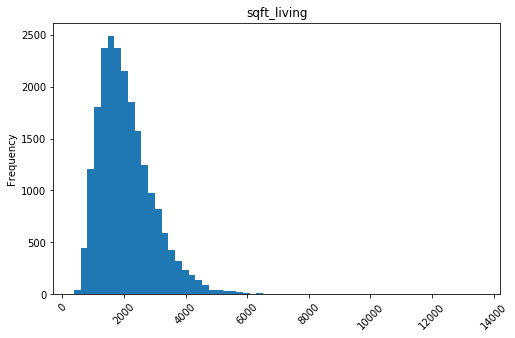

In [4]:
dff.sqft_living.plot(kind='hist', bins=60, title='sqft_living', figsize=(8,5), rot='45')

in the histogram above:
- __*sqft_living*__ as graphed above seems to indicate that the majority of the houses in this
    dataset are between 1000 sqft and 3000 sqft.
- There is a large amount between 3000 and 4500 which may be significant
- The distribution is not normal, and is skewed to the left with a long tail

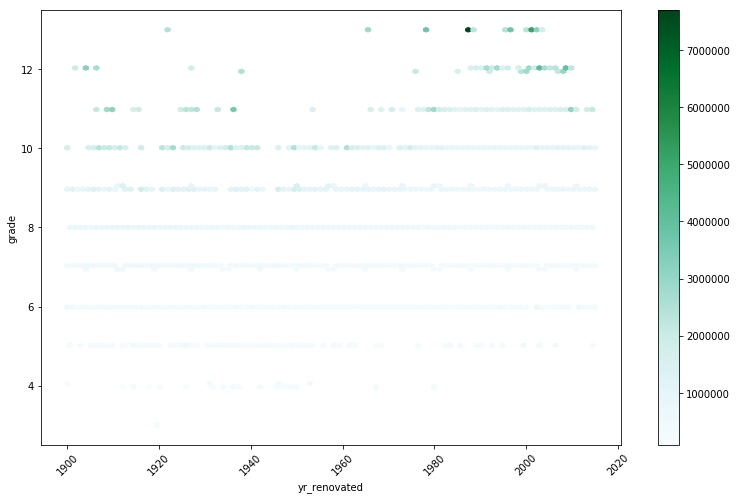

In [5]:
dff.plot.hexbin(x='yr_renovated', y='grade', C='price', figsize=(13,8),sharex=False, rot=45, legend=True)

In the hexbin plot above: 
- it appears that as the __*grade*__ of the house increases, the __*price*__ of the house also increases.
- It also appears that the __*yr_renovated*__ does not have much impact on the grade.

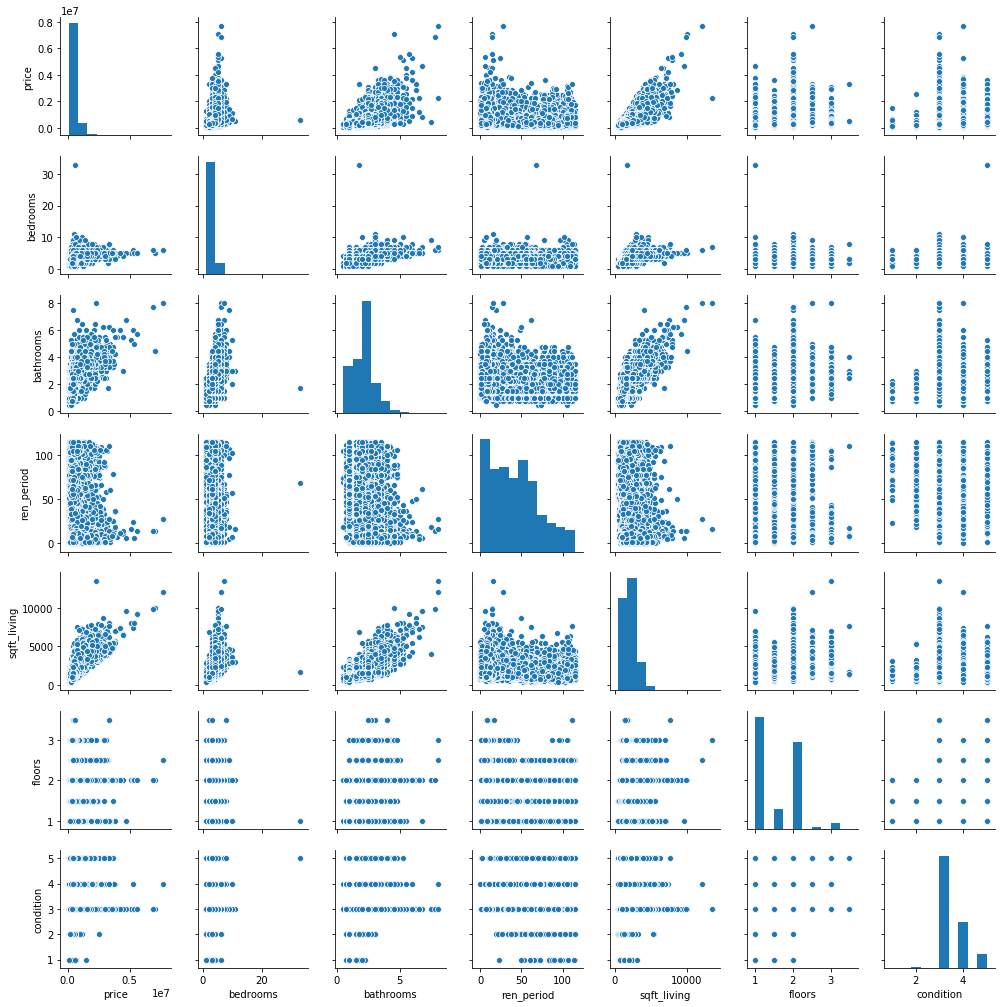

In [6]:
hf.make_pairplot(df=dff)

In the above pairplot, the following observations were made:
- __*bedrooms*__ seems to have a relationship with __*price,sqft_living, and bathrooms*__.
- __*sqft_lliving*__ and __*price*__ seem to have a linear relationship
- __*sqft_living and bathrooms*__ seem to have a direct correlation to each other.
- there are a few outliers that appear to be skewing the data, we will need to remove those.

#### Outliers have been identified and we will remove those for analysis
- __*bathrooms*__ above 10
- __*bedrooms*__ above 10
- __*sqft_living*__ above 10000
- __*grade*__ of 13 which is a top of the line custom home.  
- __*sqft_lot*__ above 750000

In [4]:
dff_working = dff.loc[
                      (dff['bathrooms']< 10) & 
                      (dff['bedrooms']<10) & 
                      (dff['sqft_living']<10000) & 
                      (dff['grade']<13) &
                      (dff['sqft_lot']<750000)
                      ]

In [5]:
dff_working.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,ren_period,yr_renovated_dt,date_dt
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,...,1955,1955.0,98178,47.5112,-122.257,1340,5650,60.0,1955,2014-10-13
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,24.0,1991,2014-12-09
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,...,1933,1933.0,98028,47.7379,-122.233,2720,8062,82.0,1933,2015-02-25
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,1965,1965.0,98136,47.5208,-122.393,1360,5000,50.0,1965,2014-12-09
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,1987,1987.0,98074,47.6168,-122.045,1800,7503,28.0,1987,2015-02-18


In [6]:
dff_working.drop('yr_renovated', inplace=True, axis=1)

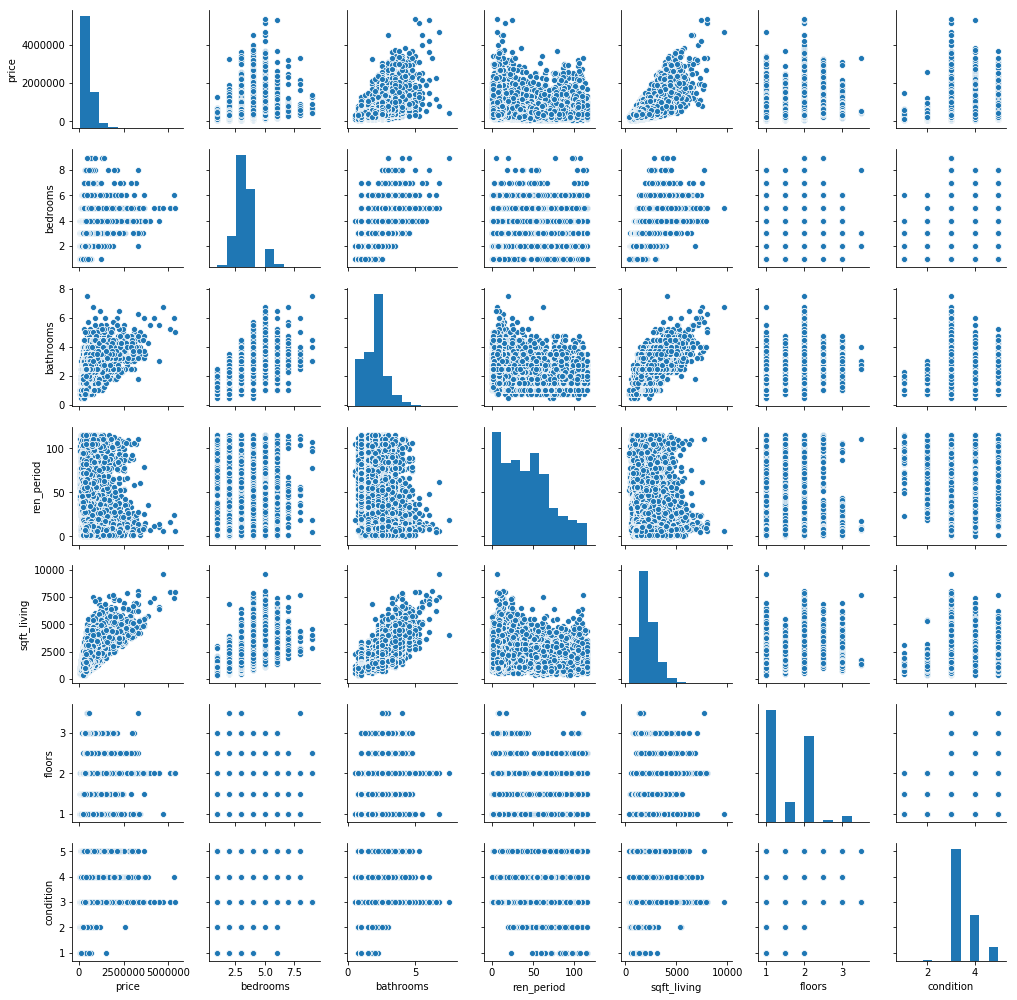

In [10]:
hf.make_pairplot(df=dff_working, kind='scatter')

#### It appears that the cleaning we have done was successful.<br>


Text(0.5, 1.0, 'Price vs 1st group of column variables')

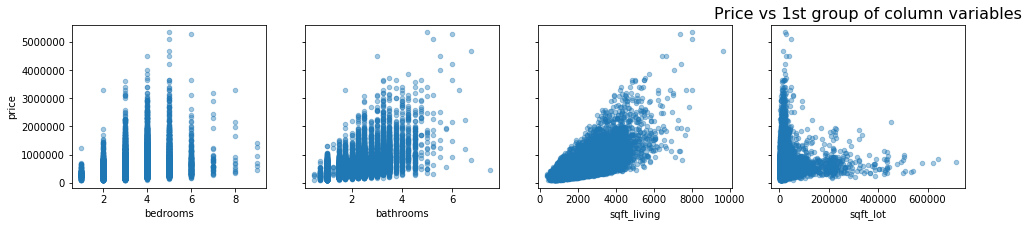

In [11]:

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
for xcol, ax in zip(list(dff_working)[2:6], axes):
                    dff_working.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=.4, sharey=True)
        

plt.title('Price vs 1st group of column variables', fontsize = 16)


Text(0.5, 1.0, 'Price vs 2nd group of column variables')

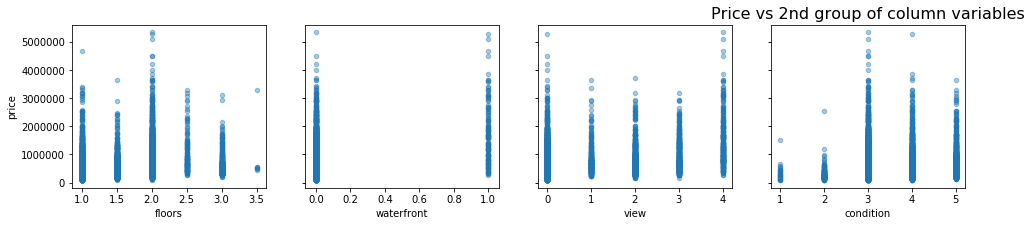

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
for xcol, ax in zip(list(dff_working)[6:10], axes):
                    dff_working.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=.4, sharey=True)

plt.title('Price vs 2nd group of column variables', fontsize = 16)

Text(0.5, 1.0, 'Price vs 3rd group of column variables')

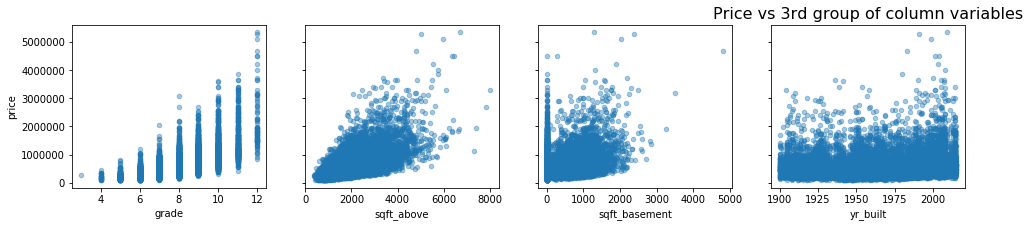

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
for xcol, ax in zip(list(dff_working)[10:14], axes):
                    dff_working.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=.4, sharey=True)

plt.title('Price vs 3rd group of column variables', fontsize = 16)

Text(0.5, 1.0, 'Price vs 4th group of column variables')

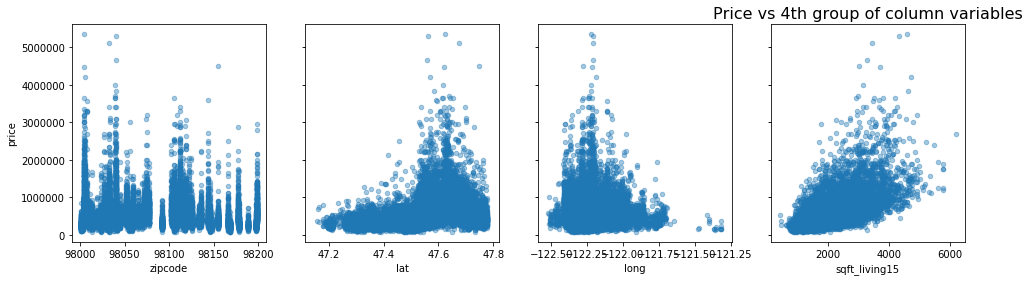

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
for xcol, ax in zip(list(dff_working)[14:18], axes):
                    dff_working.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=.4, sharey=True)

plt.title('Price vs 4th group of column variables', fontsize = 16)

Latitude and longitude seem to be related.  Let's plot them together to see what it looks like.

Text(0.5, 1.0, 'Price by Location')

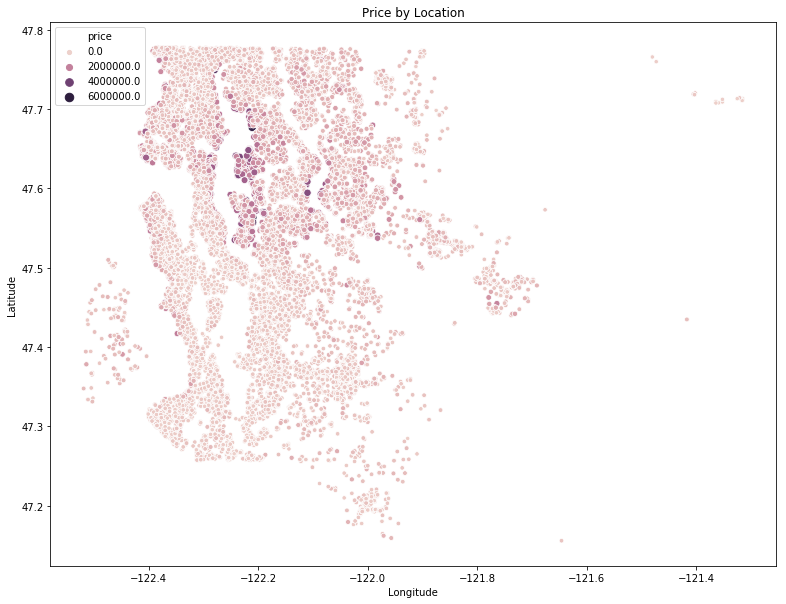

In [15]:
plt.figure(figsize=(13,10))
cmap = sns.cubehelix_palette(8, start=2, rot=.2, dark=0, light=.95, as_cmap=True)
sns.scatterplot(x='long', y='lat', data=dff_working, hue='price', size='price', cmap=cmap, )
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Price by Location')


This plot seems to indicate that there is an area where high priced houses are concentrated.
We will use this information later.


### Looking at the plots above, we have determined that we will look further into:
- __*bathrooms*__
- __*sqft_living*__
- __*bedrooms*__
- __*lat & long*__ <br>
as they relate to our target __*price*__

### Now to check for Mulitcolilnearity
 using the Pearson test, we can look for high correlation between two variables<br>
 to determine if they represent the same data.<br> 
 We will look at the values at 75% or higher and determine if we should drop one 

In [16]:
dff_working.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,ren_period,yr_renovated_dt
price,1.000000,0.317376,0.519632,0.693977,0.091514,0.260031,0.266125,0.393171,0.039827,0.670599,0.596420,0.311363,0.055809,-0.054197,0.315598,0.023194,0.591711,0.076440,-0.096550,0.096550
bedrooms,0.317376,1.000000,0.527331,0.596392,0.037498,0.182676,-0.002881,0.077620,0.023567,0.366299,0.493481,0.299739,0.163283,-0.159273,-0.012497,0.138257,0.405160,0.030910,-0.170622,0.170622
bathrooms,0.519632,0.527331,1.000000,0.751920,0.091040,0.503419,0.062941,0.179000,-0.126445,0.662665,0.681701,0.269617,0.511009,-0.206178,0.022462,0.226361,0.568086,0.080268,-0.534786,0.534786
sqft_living,0.693977,0.596392,0.751920,1.000000,0.187129,0.354461,0.102499,0.274899,-0.058659,0.761580,0.873471,0.420162,0.323367,-0.202875,0.050302,0.245231,0.759930,0.177735,-0.342120,0.342120
sqft_lot,0.091514,0.037498,0.091040,0.187129,1.000000,-0.012617,0.027021,0.076750,-0.008012,0.124042,0.197871,0.015267,0.062184,-0.144183,-0.098084,0.251453,0.167917,0.769846,-0.061805,0.061805
floors,0.260031,0.182676,0.503419,0.354461,-0.012617,1.000000,0.020441,0.026420,-0.264060,0.459059,0.526030,-0.246795,0.490039,-0.059873,0.048940,0.126034,0.279570,-0.016462,-0.500922,0.500922
waterfront,0.266125,-0.002881,0.062941,0.102499,0.027021,0.020441,1.000000,0.382324,0.017052,0.082448,0.069358,0.081469,-0.023990,0.029794,-0.012546,-0.037760,0.083052,0.032995,0.007433,-0.007433
view,0.393171,0.077620,0.179000,0.274899,0.076750,0.026420,0.382324,1.000000,0.046554,0.244571,0.157663,0.267223,-0.055474,0.085810,0.005458,-0.078659,0.275711,0.069054,0.027979,-0.027979
condition,0.039827,0.023567,-0.126445,-0.058659,-0.008012,-0.264060,0.017052,0.046554,1.000000,-0.146479,-0.159193,0.170079,-0.361615,0.002788,-0.014726,-0.105477,-0.092676,-0.001633,0.390179,-0.390179
grade,0.670599,0.366299,0.662665,0.761580,0.124042,0.459059,0.082448,0.244571,-0.146479,1.000000,0.753483,0.158725,0.450088,-0.187119,0.112796,0.201212,0.712925,0.116239,-0.460517,0.460517


In [17]:
abs(dff_working.corr()) >.75


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,ren_period,yr_renovated_dt
price,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
floors,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
grade,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False


- It looks like 'grade' is correlated with 'sqft_living', but this relationship should be expected
- 'bathrooms' and 'sqft_living15' seem to be correlated.  
  upon further inspection it seems to indicate that 'sqft_living15' may be the size before remodeling and sqft_living is the current size.  
  We will look at this closer  
- It looks like 'lat' and 'long' may have some importance, but they need to be used together.  
  We will separate them out for further inspection.

In [18]:
dff_working.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21566 entries, 0 to 21596
Data columns (total 22 columns):
date               21566 non-null object
price              21566 non-null float64
bedrooms           21566 non-null int64
bathrooms          21566 non-null float64
sqft_living        21566 non-null int64
sqft_lot           21566 non-null int64
floors             21566 non-null float64
waterfront         21566 non-null float64
view               21566 non-null float64
condition          21566 non-null int64
grade              21566 non-null int64
sqft_above         21566 non-null int64
sqft_basement      21566 non-null float64
yr_built           21566 non-null int64
zipcode            21566 non-null int64
lat                21566 non-null float64
long               21566 non-null float64
sqft_living15      21566 non-null int64
sqft_lot15         21566 non-null int64
ren_period         21566 non-null float64
yr_renovated_dt    21566 non-null int64
date_dt            21566 non-nul

In [7]:
cols = ['bedrooms', 'bathrooms', 'ren_period', 'sqft_living', 'floors', 'condition']
hf.make_ols_model(df=dff_working, columns_to_use=cols, summary=True)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                 2.163e+04
Date:                Wed, 11 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:36:37   Log-Likelihood:            -2.9802e+05
No. Observations:               21566   AIC:                         5.961e+05
Df Residuals:                   21560   BIC:                         5.961e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
bedrooms    -8.311e+04   2236.572    -37.160      

(<statsmodels.regression.linear_model.OLS at 0x1bc2f23c7b8>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1bc2f23c630>)

### Summary 1: All Columns
- Model
    - R2 is .85
        - but given the **multicollinearity** this number is highly unreliable
- Features
    - Our coefficients are also unreliable, since we have such high multicollinearity
    - Pvalues are all under 0.05
- Residuals
    - Skewed to the right, which means our line is below our data
    - Kurtosis is very high, which means our data is far away (35 standard deviations) from the line
    - Condition Number is infinity, which means we have multicollinearity

In [8]:
cols = ['grade', 'lat', 'condition']

hf.make_ols_model(df=dff_working, columns_to_use=cols, summary=True)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                 3.728e+04
Date:                Wed, 11 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:36:42   Log-Likelihood:            -2.9938e+05
No. Observations:               21566   AIC:                         5.988e+05
Df Residuals:                   21563   BIC:                         5.988e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
grade       2.084e+05   1532.464    135.990      0.0

(<statsmodels.regression.linear_model.OLS at 0x1bc2f23c5f8>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1bc2e21e400>)

### Summary 2: Grade, Latitude and Condition
- Model
    - R2 is .83
        - but given the **multicollinearity** this number is highly unreliable
- Features
    - Our coefficients are also unreliable, since we have such high multicollinearity
    - Pvalues are all under 0.05
- Residuals
    - Still skewed to the right, which means our line is below our data
    - Kurtosis is very high, which means our data is far away (25 standard deviations) from the line
    - Condition Number is much better, but we still have multicollinearity

In [9]:
cols = ['waterfront', 'lat', 'bedrooms', 'condition']

hf.make_ols_model(df=dff_working, columns_to_use=cols, summary=True)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                 1.624e+04
Date:                Wed, 11 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:36:43   Log-Likelihood:            -3.0405e+05
No. Observations:               21566   AIC:                         6.081e+05
Df Residuals:                   21562   BIC:                         6.081e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
waterfront  1.152e+06   2.68e+04     43.040      0.0

(<statsmodels.regression.linear_model.OLS at 0x1bc309e6d68>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1bc309e6f60>)

### Summary 3: Waterfront, Latitude, Bedrooms, Condition
- Model
    - R2 is .75
        - but given the **multicollinearity** this number is highly unreliable
- Features
    - Our coefficients are also unreliable, since we have such high multicollinearity
    - Pvalues are all under 0.05
- Residuals
    - Still skewed to the right, which means our line is below our data
    - Kurtosis is still high, which means our data is far away (18 standard deviations) from the line
    - Condition Number is much worse, and we still have multicollinearity

In [10]:
cols = ['lat', 'long', 'grade']

hf.make_ols_model(df=dff_working, columns_to_use=cols, summary=True)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                 3.926e+04
Date:                Wed, 11 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:36:44   Log-Likelihood:            -2.9891e+05
No. Observations:               21566   AIC:                         5.978e+05
Df Residuals:                   21563   BIC:                         5.979e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lat         4.922e+05   1.24e+04     39.799      0.0

(<statsmodels.regression.linear_model.OLS at 0x1bc309e6e10>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1bc29114860>)

### Summary 4: Latitude, Longitude, Grade
- Model
    - R2 is .84
        - but given the **multicollinearity** this number is highly unreliable
- Features
    - Our coefficients are also unreliable, since we have such high multicollinearity
    - Pvalues are all under 0.05
- Residuals
    - Still skewed to the right, which means our line is below our data
    - Kurtosis is much higher, which means our data is far away (29 standard deviations) from the line
    - Condition Number is very large because we still have multicollinearity

### Looking for and removing Multi_Colinearity

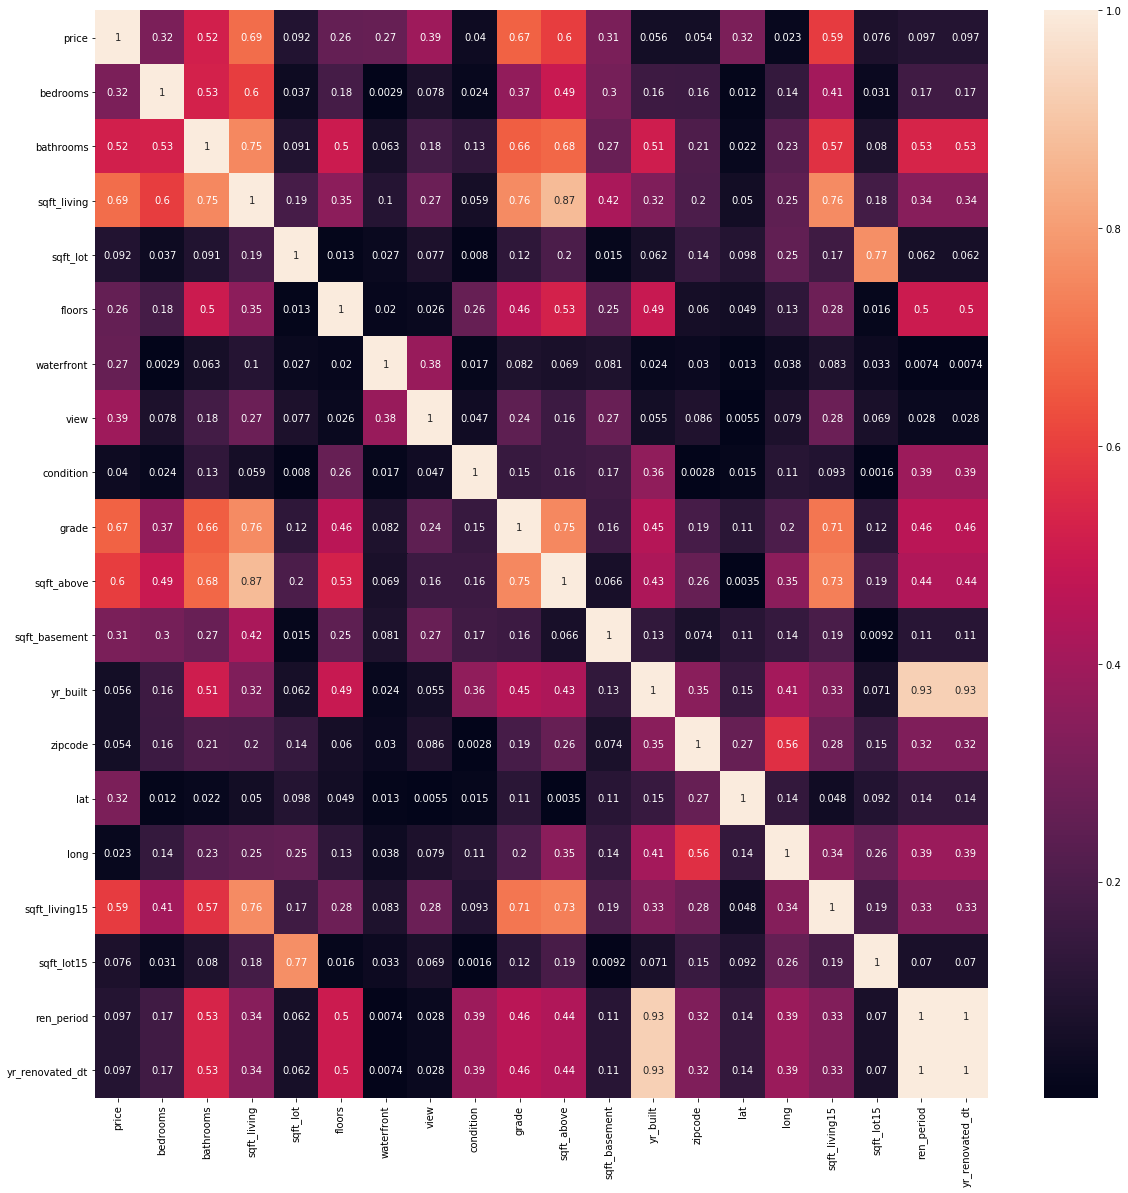

In [24]:
corr = dff_working.corr()
plt.figure(figsize=(20,20))
sns.heatmap(np.abs(corr), annot=True,)
plt.show()

In the heatmap above we can see that there are a few features that are multicolinear with many others.  
We will attempt to engineer some features from those to see if they can still be effective.  
'sqft_living' and 'grade' have a high correlation, so we will combine them into one feature.

In [11]:
np.corrcoef(dff_working.bedrooms, dff_working.sqft_living)

array([[1.        , 0.59639237],
       [0.59639237, 1.        ]])

In [12]:
weights = np.linspace(0, 1, 10000)
max_corr = -1
desired_weights = None
for weight in weights:
    weight1 = weight
    weight2 = 1 - weight
    vals = weight1*dff_working.bedrooms + weight2*dff_working.sqft_living
    corr_coeff = np.abs(np.corrcoef(vals, dff_working.price))[0][1]
    if corr_coeff > max_corr:
        desired_weights = [weight1, weight2]
        max_corr = corr_coeff
desired_weights

[0.0, 1.0]

In [13]:
dff_working['sqft_living_bedrooms'] = desired_weights[0]*dff_working.bedrooms + desired_weights[1]*dff_working.sqft_living

In [14]:
cols = ['sqft_living_bedrooms']
hf.make_ols_model(df=dff_working, columns_to_use=cols, summary=True)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                 1.162e+05
Date:                Wed, 11 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:37:02   Log-Likelihood:            -2.9904e+05
No. Observations:               21566   AIC:                         5.981e+05
Df Residuals:                   21565   BIC:                         5.981e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
sqft_living_bedrooms   261.1745 

(<statsmodels.regression.linear_model.OLS at 0x1bc309f52b0>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1bc309f54a8>)

In [15]:
np.corrcoef(dff_working.bathrooms, dff_working.grade)

array([[1.        , 0.66266476],
       [0.66266476, 1.        ]])

__*bathrooms*__ and __*grade*__ are colinear, so we will create a new feature combining the  
two into one feature, __*grade_bathroom*__.


In [16]:
weights = np.linspace(0, 1, 10000)
max_corr = -1
desired_weights = None
for weight in weights:
    weight1 = weight
    weight2 = 1 - weight
    vals = weight1*dff_working.bathrooms + weight2*dff_working.grade
    corr_coeff = np.abs(np.corrcoef(vals, dff_working.price))[0][1]
    if corr_coeff > max_corr:
        desired_weights = [weight1, weight2]
        max_corr = corr_coeff
desired_weights

[0.26042604260426044, 0.7395739573957396]

In [17]:
dff_working['grade_bathroom'] = desired_weights[0]*dff_working.bathrooms + desired_weights[1]*dff_working.grade

In [18]:
dff_working.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21566 entries, 0 to 21596
Data columns (total 24 columns):
date                    21566 non-null object
price                   21566 non-null float64
bedrooms                21566 non-null int64
bathrooms               21566 non-null float64
sqft_living             21566 non-null int64
sqft_lot                21566 non-null int64
floors                  21566 non-null float64
waterfront              21566 non-null float64
view                    21566 non-null float64
condition               21566 non-null int64
grade                   21566 non-null int64
sqft_above              21566 non-null int64
sqft_basement           21566 non-null float64
yr_built                21566 non-null int64
zipcode                 21566 non-null int64
lat                     21566 non-null float64
long                    21566 non-null float64
sqft_living15           21566 non-null int64
sqft_lot15              21566 non-null int64
ren_period         

In [19]:
dff_working = dff_working.drop('date_dt', axis=1)
dff_working = dff_working.drop('date', axis=1)



In [20]:
dff_working = dff_working.drop('grade_bathroom', axis=1)

Here we are using scikit learn's recursive feature elimination to help  
determine which features to select for our model.

In [21]:
cols = ['bathrooms', 'waterfront', 'ren_period']
model, results = hf.make_ols_model(df=dff_working, columns_to_use=cols, summary=True)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                 2.941e+04
Date:                Wed, 11 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:37:39   Log-Likelihood:            -3.0148e+05
No. Observations:               21566   AIC:                         6.030e+05
Df Residuals:                   21563   BIC:                         6.030e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bathrooms   2.267e+05   1169.827    193.769      0.0

After running a few models, taking out and including various features, we have settled on the following:  
__*'sqft_lot', 'waterfront', 'condition', 'sqft_basement', 'ren_period', sqft_living_bedrooms', 'grade_bathroom'

In [22]:
features = dff_working.drop(columns=['bedrooms', 'bathrooms', 'view', 'grade', 'sqft_living', 'floors', 'sqft_above', 'sqft_lot15', 'yr_built', 'yr_renovated_dt', 'sqft_living15', 'long', 'zipcode'])
features.head()

,price,sqft_lot,waterfront,condition,sqft_basement,lat,ren_period,sqft_living_bedrooms
0,221900.0,5650,0.0,3,0.0,47.5112,60.0,1180.0
1,538000.0,7242,0.0,3,400.0,47.7210,24.0,2570.0
2,180000.0,10000,0.0,3,0.0,47.7379,82.0,770.0
3,604000.0,5000,0.0,5,910.0,47.5208,50.0,1960.0
4,510000.0,8080,0.0,3,0.0,47.6168,28.0,1680.0


In [23]:
sel = RFE(estimator=LinearRegression(), n_features_to_select=4)
sel = sel.fit(features, features['price'])
estimator = sel.estimator_

features_ranked = zip(features.columns,sel.ranking_)
sorted_features = sorted(features_ranked, key=lambda tup: tup[1])

#Iterate through sorted features and print their rank
for col, rank in sorted_features:
    print("{}. {}".format(rank,col))

1. price
1. waterfront
1. condition
1. lat
2. ren_period
3. sqft_basement
4. sqft_living_bedrooms
5. sqft_lot


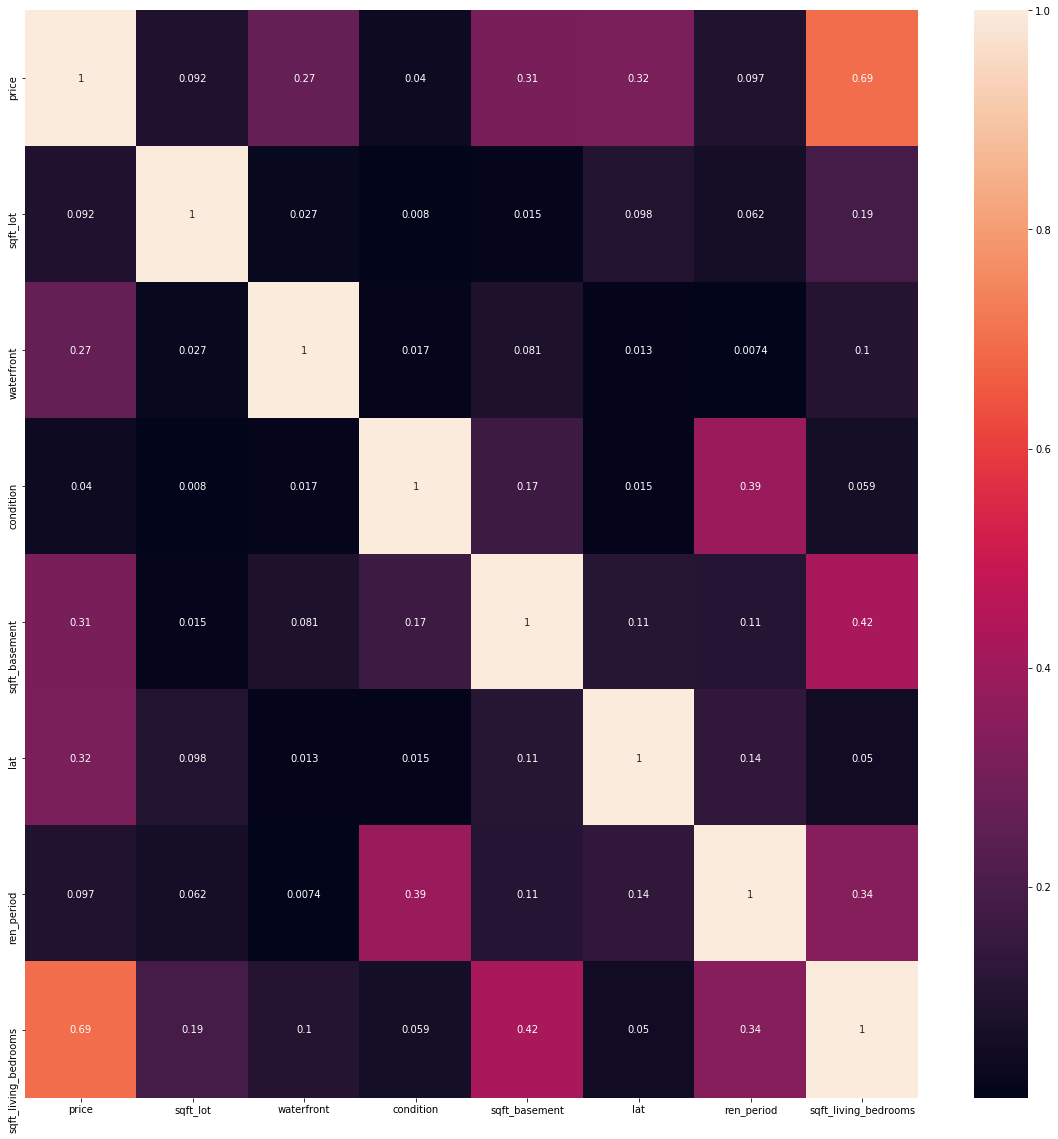

In [24]:
corr = features.corr()
plt.figure(figsize=(20,20))
sns.heatmap(np.abs(corr), annot=True,)
plt.show()

From this correlation heatmap, it appears that we were successful in removing much of  
the multicolinearity.

In [25]:
cols = ['ren_period', 'lat', 'condition']
hf.make_ols_model(df=features, target='price', columns_to_use=cols, summary=True)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                 1.711e+04
Date:                Wed, 11 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:37:47   Log-Likelihood:            -3.0590e+05
No. Observations:               21566   AIC:                         6.118e+05
Df Residuals:                   21563   BIC:                         6.118e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ren_period -1613.2888     89.401    -18.046      0.0

(<statsmodels.regression.linear_model.OLS at 0x1bc30c9f898>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1bc30cf3c18>)

Lets take a look at a graph of our selected features.

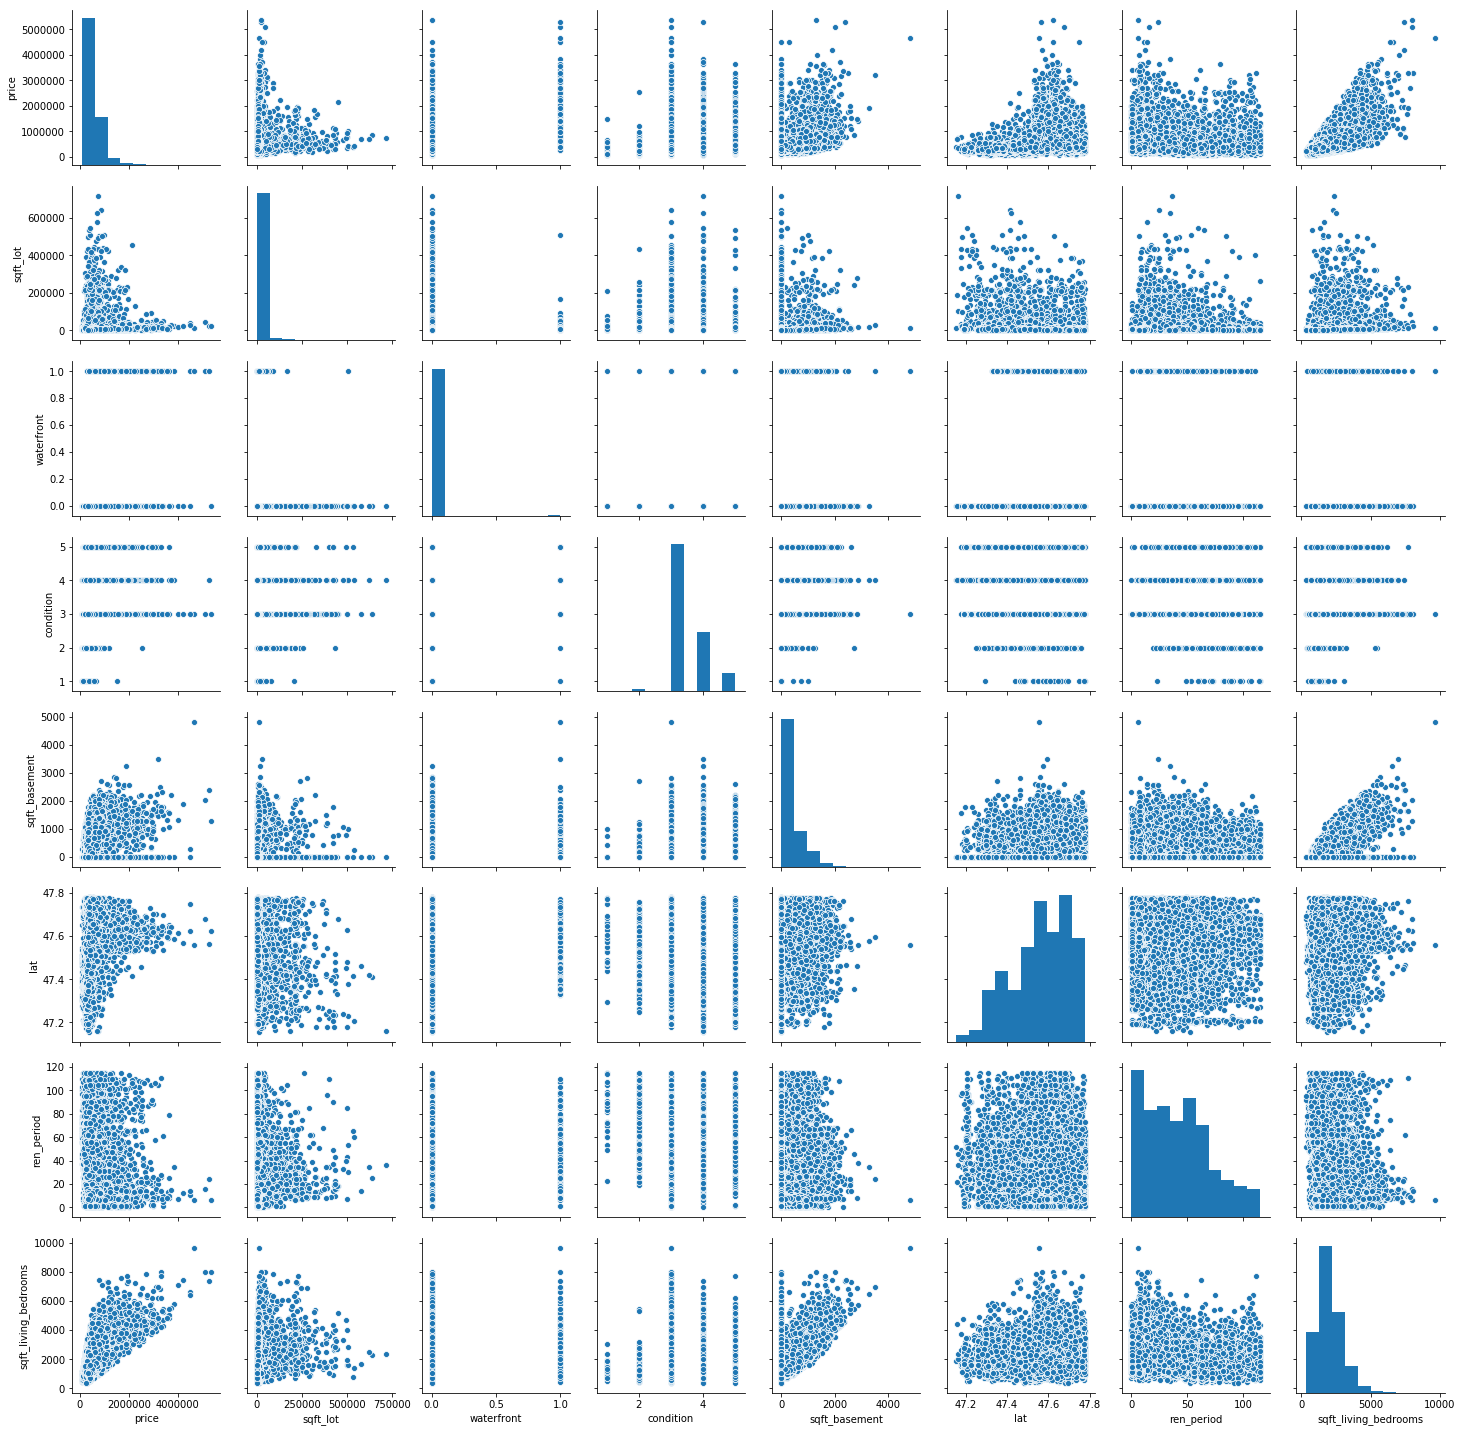

In [26]:
sns.pairplot(data=features)

In [27]:
# Much of the data seems to be not normal.  
# We will perform a log transformation in an effort to normalize the data
features_treated = pd.DataFrame([])

In [28]:
features_treated['price'] = np.log(features['price'])
features_treated['sqft_lot'] = np.log(features['sqft_lot'])
features_treated['sqft_living_bedrooms'] = np.log(features['sqft_living_bedrooms'])

Text(0.5, 1.0, 'Price vs 1st group of column variables')

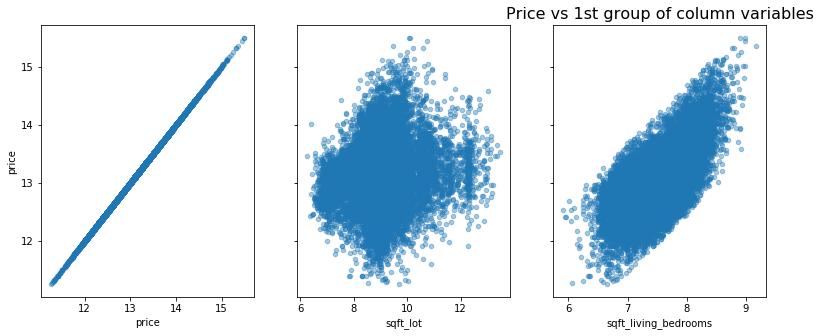

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13,5))
for xcol, ax in zip(list(features_treated)[0:3], axes):
                    features_treated.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=.4, sharey=True)

plt.title('Price vs 1st group of column variables', fontsize = 16)

In [30]:
features_treated['sqft_basement'] = (features.sqft_basement - min(features.sqft_basement)) / (max(features.sqft_basement) - min(features.sqft_basement))

#### This seems to have made a difference in the data.

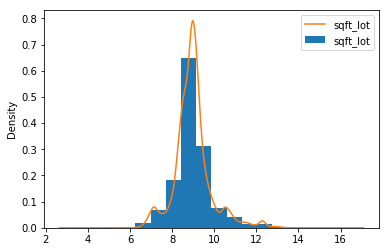

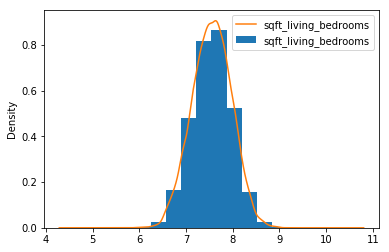

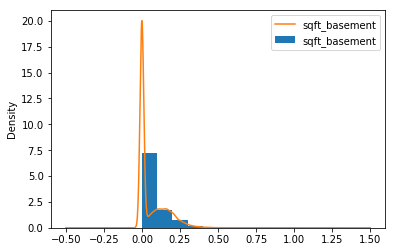

In [45]:
cols = ['sqft_lot', 'sqft_living_bedrooms', 'sqft_basement']
hf.make_kde(data=features_treated, columns=cols)

### From this plot, we have learned<br>
- We were able to normalize the data.


In [31]:
features_final = pd.DataFrame()
cols = ['price','sqft_lot', 'sqft_living_bedrooms', 'sqft_basement']
for col in cols:
    features_final[col] = features_treated[col]
features_final.head()

,price,sqft_lot,sqft_living_bedrooms,sqft_basement
0,12.309982,8.639411,7.073270,0.000000
1,13.195614,8.887653,7.851661,0.082988
2,12.100712,9.210340,6.646391,0.000000
3,13.311329,8.517193,7.580700,0.188797
4,13.142166,8.997147,7.426549,0.000000


In [32]:
features_final['ren_period'] = features['ren_period']
features_final['condition'] = features['condition']
features_final['lat'] = features['lat']

### Now that we have the data organized, lets start looking at the relationships.

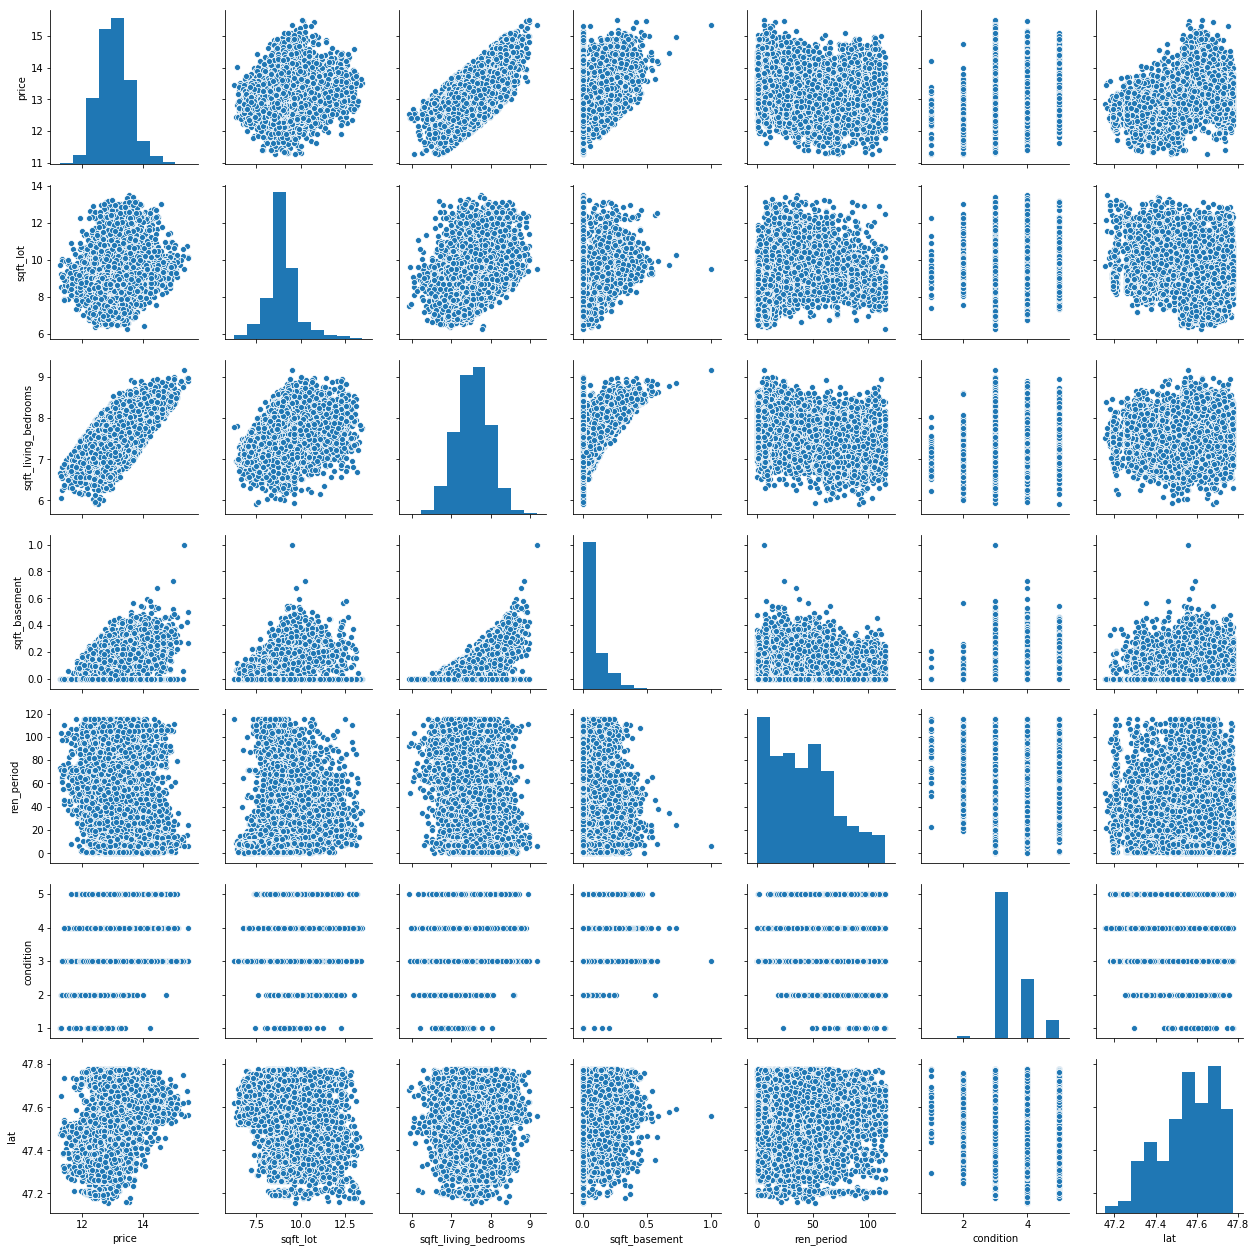

In [48]:
sns.pairplot(features_final)

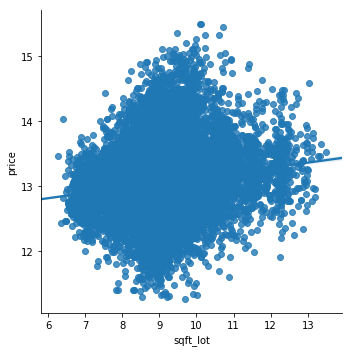

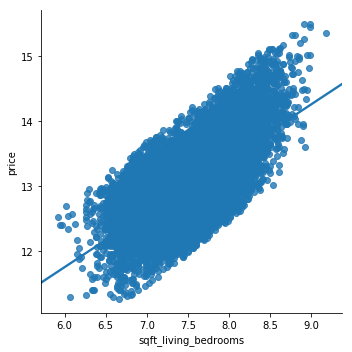

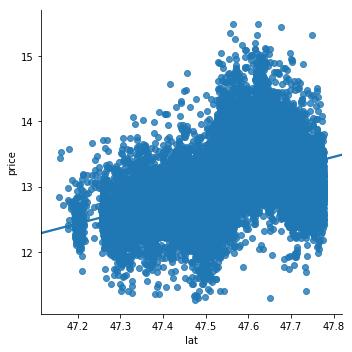

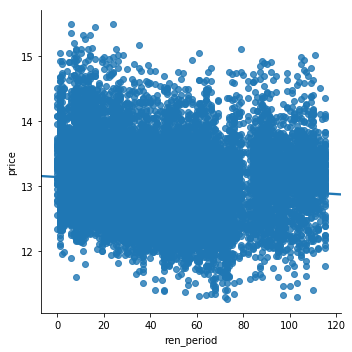

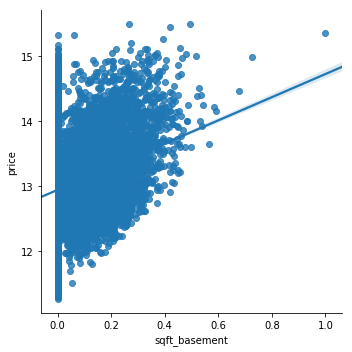

In [49]:
for column in ['sqft_lot', 'sqft_living_bedrooms', 'lat', 'ren_period', 'sqft_basement']:
    sns.lmplot(x=column, y="price",
                  data=features_final)
    plt.show()

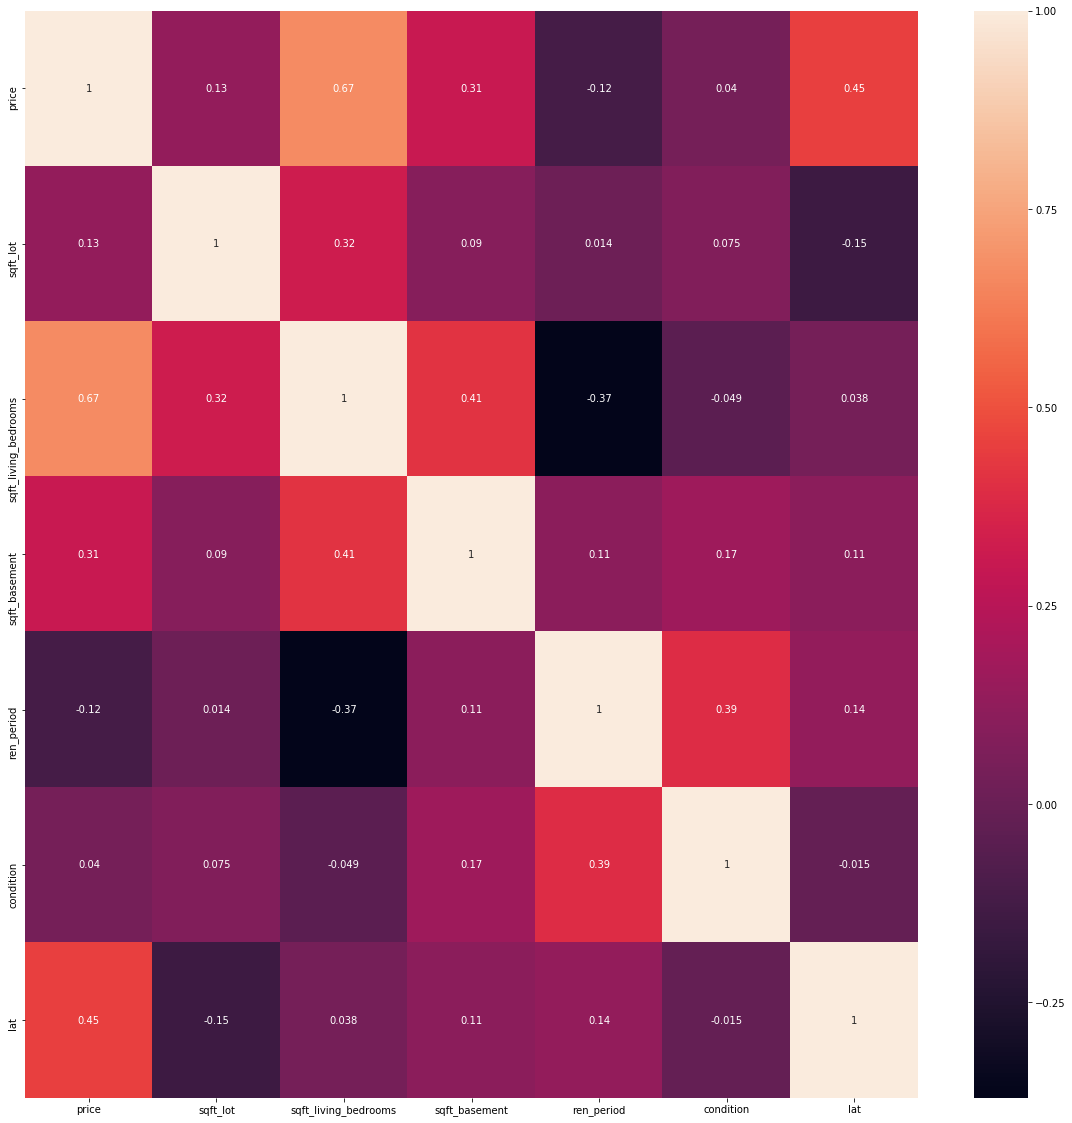

In [50]:
corr = features_final.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True,)
plt.show()

In [33]:
features_final.head()

,price,sqft_lot,sqft_living_bedrooms,sqft_basement,ren_period,condition,lat
0,12.309982,8.639411,7.073270,0.000000,60.0,3,47.5112
1,13.195614,8.887653,7.851661,0.082988,24.0,3,47.7210
2,12.100712,9.210340,6.646391,0.000000,82.0,3,47.7379
3,13.311329,8.517193,7.580700,0.188797,50.0,5,47.5208
4,13.142166,8.997147,7.426549,0.000000,28.0,3,47.6168


In [34]:
col_names = features_final.describe().columns.drop(['price'])
results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value' ]]
for idx, val in enumerate(col_names):
    print ("Price~" + val)
    print ("------------------------------")

    f = 'price~' + val
    model = smf.ols(formula=f, data=features_final).fit()
    X_new = pd.DataFrame({val: [features_final[val].min(), features_final[val].max()]});
    preds = model.predict(X_new)
    results.append([val, model.rsquared, model.params[0], model.params[1], model.pvalues[1]])
    print (results[idx+1])

Price~sqft_lot
------------------------------
['sqft_lot', 0.01776913784845291, 12.345547832711205, 0.07799260152670728, 4.5279825269091326e-86]
Price~sqft_living_bedrooms
------------------------------
['sqft_living_bedrooms', 0.45122549562539416, 6.758188085524836, 0.8329451275649388, 0.0]
Price~sqft_basement
------------------------------
['sqft_basement', 0.09475698122496534, 12.941402440517544, 1.7786531756918782, 0.0]
Price~ren_period
------------------------------
['ren_period', 0.014538635135167843, 13.13821995112877, -0.002182037155658314, 1.1875365265727518e-70]
Price~condition
------------------------------
['condition', 0.0016192391585556631, 12.935958532050405, 0.03239507765393057, 3.391924266123497e-09]
Price~lat
------------------------------
['lat', 0.20284297077390412, -67.9056778459724, 1.7021030989406818, 0.0]


In [35]:
cols = ['sqft_living_bedrooms', 'condition', 'lat']
model, results = hf.make_ols_model(features_final, columns_to_use=cols, add_constant=True)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                 1.269e+04
Date:                Wed, 11 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:38:50   Log-Likelihood:                -5684.8
No. Observations:               21566   AIC:                         1.138e+04
Df Residuals:                   21562   BIC:                         1.141e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -70.0350      0.737    -95.086      0.000     -71.479     -68.591
sqft_living_bedrooms     0.8178      0.005    160.731      0.000       0.808       0.828
condition                0.0634      0.003     19.220      0.000       0.057       0.070
lat                      1.6125      0.015    104.101      0.000       1.582       1.643
==============================================================================
Omnibus:                      616.629   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              789.089
Skew:                           0.343   Prob(JB):                    4.48e-172
Kurtosis:                       3.638   Cond. No.                     1.66e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Features Model Summary
- Model
    - R2 is .63
        - 
- Features
    - Our coefficients are also unreliable, since we have such high multicollinearity
    - Pvalues are all under 0.05
- Residuals
    - Slightly skewed to the right, which means our line is below our data
    - Kurtosis is much better at 3.6, which means our data is 3.6 standard deviations from the line
    - Condition Number is very high

In [36]:
y = features_final[['price']]
X = features_final.drop(['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

In [37]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

17252 4314 17252 4314


In [38]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [39]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [40]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: price    0.097793
dtype: float64
Test Mean Squarred Error: price    0.098898
dtype: float64


In [41]:
print(linreg.intercept_)

[-68.73529949]


In [42]:
y_pred = linreg.predict(X_test)

In [43]:
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.24157621479870175
0.09889846934376009
0.31448127025907296


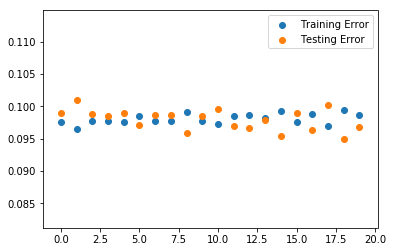

In [44]:
num = 20
train_err = []
test_err = []
for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(metrics.mean_squared_error(y_train, y_hat_train))
    test_err.append(metrics.mean_squared_error(y_test, y_hat_test))
plt.scatter(list(range(num)), train_err, label='Training Error')
plt.scatter(list(range(num)), test_err, label='Testing Error')
plt.legend();

__K-Fold Cross-Validation__

In [51]:
cv_5_results  = np.mean(cross_val_score(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='neg_mean_squared_error'))

In [52]:
print(cv_5_results)

-0.09869915558564062
